# ♻️ OBJECT DETECTION USING YOLOv8 ON CUSTOM WASTE BANK DATASET ♻️
The goal of this project is to utilize the YOLOv8 model for object detection to accurately identify and classify waste materials sorted at a waste bank, leveraging a custom dataset to enhance sorting accuracy and operational efficiency.
Overview of the workflow
1. Set up the notebook (jupyter) with paperspace A4000 machine
2. YOLOv8 Dependency Installation
3. Get custom dataset from git wasteapp repo
4. Visualize the train images with their bounding boxes
5. Train the custom waste bank dataset
6. Validation the model taht has been trained
7. Test and Run inference with the custom YOLOv8s Object Detection Trained Weight
8. Visualize the prediction by plotting validation images (test images) and their predicted bounding boxes

**Import the neccesary library**

In [1]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 793.7/793.7 kB 8.8 MB/s eta 0:00:00a 0:00:01


In [23]:
import ultralytics

print(ultralytics.__version__)

8.2.48


In [24]:
!pip install opencv-python-headless

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 60.8 MB/s eta 0:00:00:00:0100:01


In [13]:
!pip install matplotlib

In [15]:
import torch
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import glob
import random
import os
from ultralytics import YOLO
from PIL import Image

# Dataset

the dataset gathered 30% new images + 70% images collected from websites and annotated using roboflow, 
then split to train(70%), valid(20%), and test(10%)

The dataset has 3 folders:

train - contains ---- images.

valid - contains --- images. Care has been taken to prevent any data leakage. Any image present in the train set is not a part of the val set.

test - contains --- images.

Hence, effort has been made to create a good quality dataset because the quality of the predictions depends a lot on the quality of the dataset the model has been trained on.
Structure of the dataset:

number of classes in the dataset = 14

names: [‘Botol Kaca’, ‘Botol Plastik’, ‘Galon’, ‘Gelas Plastik’, ‘Kaleng’, ‘Kantong Plastik’, ‘Kantong Semen’, ‘Kardus’, ‘Kemasan Plastik’, ‘Kertas Bekas’, ‘Koran’, ‘Pecahan Kaca’, ‘Toples Kaca’, ‘Tutup Galon’]

dataset

|__ train

—-|______ images

—-|______ labels

|__ valid

—-|______ images

—-|______ labels

|__ test

—-|______ images

—-|______ labels


In [4]:
!git clone https://github.com/wastebank-project/machine_learning.git
#Loaded dataset from github

Cloning into 'machine_learning'...
remote: Enumerating objects: 10423, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 10423 (delta 0), reused 5 (delta 0), pack-reused 10415
Receiving objects: 100% (10423/10423), 231.01 MiB | 31.13 MiB/s, done.
Resolving deltas: 100% (25/25), done.
Updating files: 100% (18881/18881), done.


**CHECKING ISSUE IN DATASET**

In [26]:
def verify_dataset(base_path):
    subsets = ['train', 'valid', 'test']
    issues = []

    for subset in subsets:
        images_path = os.path.join(base_path, subset, 'images')
        labels_path = os.path.join(base_path, subset, 'labels')

        # Collect all image and label files
        image_files = {file for file in os.listdir(images_path) if file.endswith('.jpg')}
        label_files = {file.replace('.txt', '.jpg') for file in os.listdir(labels_path) if file.endswith('.txt')}

        # Check for missing label or image files
        missing_labels = image_files - label_files
        missing_images = label_files - image_files

        if missing_labels:
            issues.append(f'Missing labels in {subset}: {missing_labels}')
        if missing_images:
            issues.append(f'Missing images in {subset}: {missing_images}')

        # Verify image integrity
        for image_file in image_files:
            image_path = os.path.join(images_path, image_file)
            try:
                img = cv2.imread(image_path)
                if img is None:
                    raise ValueError("Cannot read the image file.")
            except Exception as e:
                issues.append(f'Corrupt image file {image_path}: {str(e)}')

    return issues

base_path = '/notebooks/dataset.yolo'

dataset_issues = verify_dataset(base_path)
if dataset_issues:
    for issue in dataset_issues:
        print(issue)
else:
    print("No issues found with the dataset.")

No issues found with the dataset.


**VISUALIZE IMAGES AND BBOX**

In [4]:
def yolo2bbox(bboxes):

    xmin, ymin = bboxes[0]-bboxes[2]/2, bboxes[1]-bboxes[3]/2
    xmax, ymax = bboxes[0]+bboxes[2]/2, bboxes[1]+bboxes[3]/2
    return xmin, ymin, xmax, ymax

In [5]:
# Function to plot the bounding boxes.

def plot_box(image, bboxes, labels):

    # Need the image height and width to denormalize the bounding box coordinates
    h, w, _ = image.shape
    for box_num, box in enumerate(bboxes):
        x1, y1, x2, y2 = yolo2bbox(box)

        # Denormalize the coordinates.
        xmin = int(x1*w)
        ymin = int(y1*h)
        xmax = int(x2*w)
        ymax = int(y2*h)

        # calculate the thickness of the bounding box lines based on the image width
        # to make sure the boxes are visible in the plot.
        thickness = max(2, int(w/275))

        # draw a rectangle on the image
        cv2.rectangle(
            image,
            (xmin, ymin), (xmax, ymax),
            #  color (0, 0, 255) -> red
            color=(0, 0, 255),
            thickness=thickness
        )
    return image

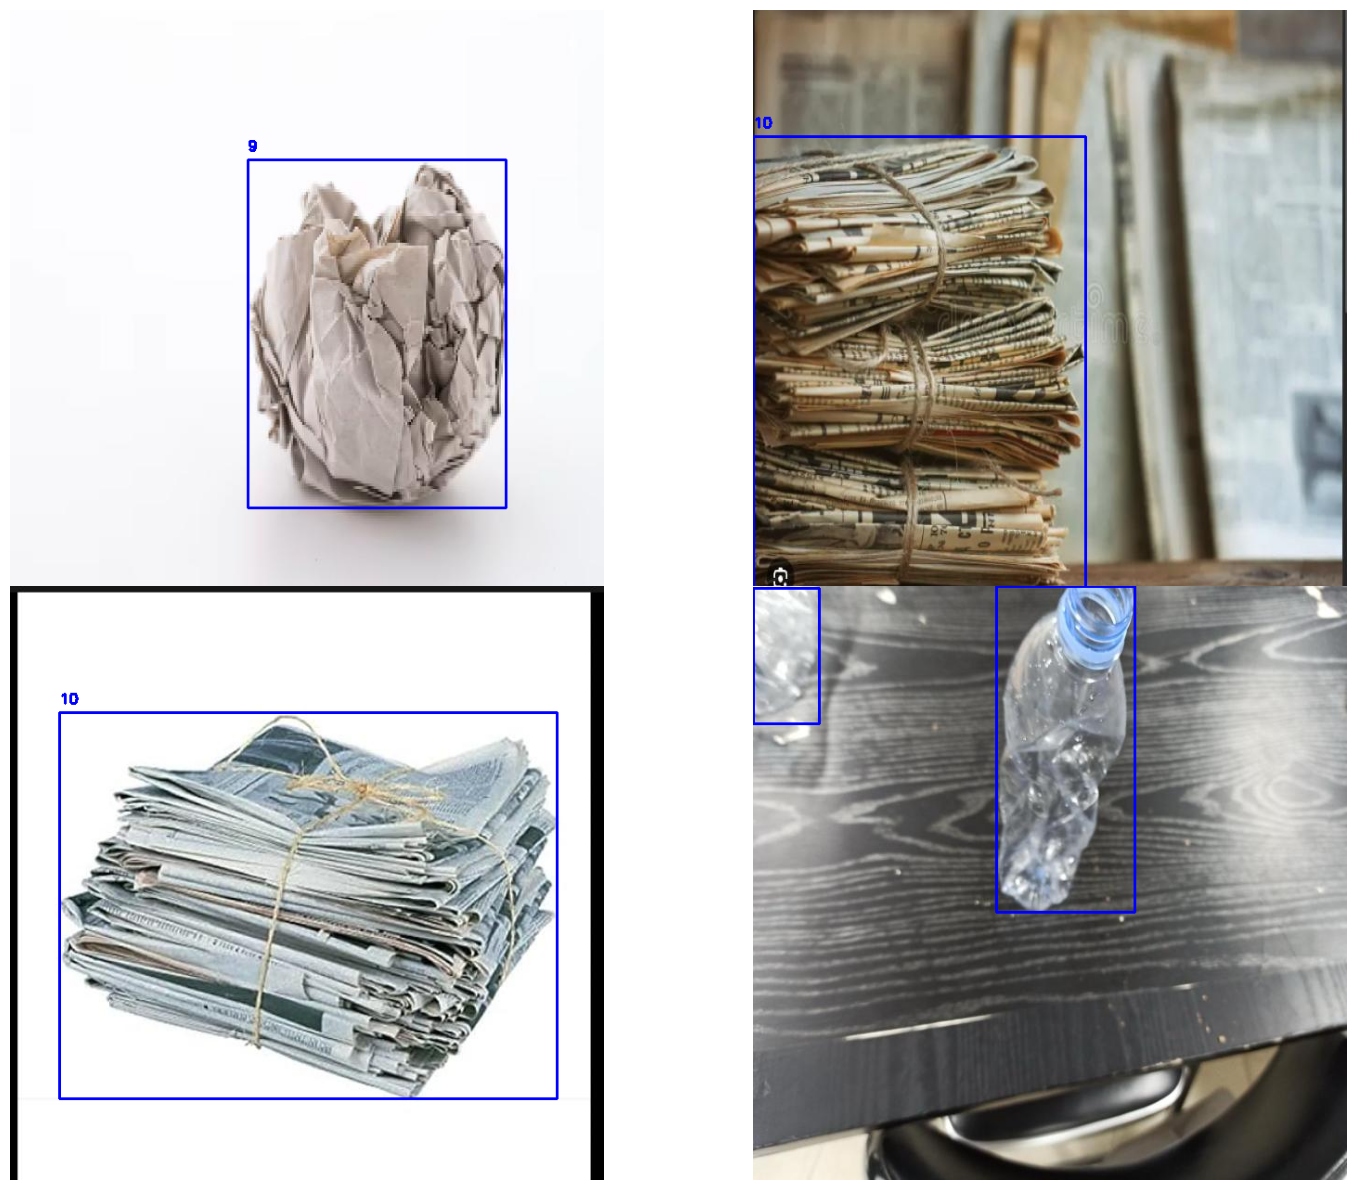

In [6]:
# Function to plot the bounding boxes.

def plot_box(image, bboxes, labels):

    # Need the image height and width to denormalize the bounding box coordinates
    h, w, _ = image.shape
    for box_num, box in enumerate(bboxes):
        x1, y1, x2, y2 = yolo2bbox(box)

        # Denormalize the coordinates.
        xmin = int(x1*w)
        ymin = int(y1*h)
        xmax = int(x2*w)
        ymax = int(y2*h)

        # calculate the thickness of the bounding box lines based on the image width
        # to make sure the boxes are visible in the plot.
        thickness = max(2, int(w/275))

        # draw a rectangle on the image
        cv2.rectangle(
            image,
            (xmin, ymin), (xmax, ymax),
            #  color (0, 0, 255) -> red
            color=(0, 0, 255),
            thickness=thickness
        )
    return image
#%%
def plot_box(image, bboxes, labels):
    """
    Draws bounding boxes and labels on the image.
    """
    for (x_c, y_c, w, h), label in zip(bboxes, labels):
        # Convert from center coordinates to corner coordinates
        x1 = int((x_c - w / 2) * image.shape[1])
        y1 = int((y_c - h / 2) * image.shape[0])
        x2 = int((x_c + w / 2) * image.shape[1])
        y2 = int((y_c + h / 2) * image.shape[0])

        # Draw the bounding box
        cv2.rectangle(image, (x1, y1), (x2, y2), (255, 0, 0), 2)
        # Place the label
        cv2.putText(image, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)
    return image

def plot(image_paths, label_paths, num_samples):
    all_images = glob.glob(os.path.join(image_paths, '*.jpg')) + glob.glob(os.path.join(image_paths, '*.JPG'))
    all_images.sort()

    plt.figure(figsize=(15, 12))
    for i in range(num_samples):
        idx = random.randint(0, len(all_images) - 1)
        image_path = all_images[idx]
        label_path = os.path.join(label_paths, os.path.basename(image_path).replace('.jpg', '.txt').replace('.JPG', '.txt'))

        image = cv2.imread(image_path)
        bboxes = []
        labels = []

        with open(label_path, 'r') as f:
            lines = f.readlines()
            for line in lines:
                parts = line.strip().split()
                if len(parts) == 5:
                    label = parts[0]
                    x_c, y_c, w, h = map(float, parts[1:])
                    bboxes.append([x_c, y_c, w, h])
                    labels.append(label)

        result_image = plot_box(image, bboxes, labels)
        plt.subplot(2, 2, i + 1)
        plt.imshow(result_image[:, :, ::-1])
        plt.axis('off')

    plt.subplots_adjust(wspace=1)
    plt.tight_layout()
    plt.show()

# visualize a few training images
plot(
    image_paths='/notebooks/dataset.yolo/train/images',
    label_paths='/notebooks/dataset.yolo/train/labels',
    num_samples=4
)

# TRAIN YOLOv8s MODEL ON CUSTOM DATASET

In [14]:
# Disable wandb by setting the environment variable
os.environ['WANDB_MODE'] = 'disabled'

# Load a pre-trained YOLOv8 small model
model = YOLO('yolov8s.pt')

# Train the model
model.train(
    data='/notebooks/dataset.yolo/data.yaml',
    optimizer= 'Adam',
    epochs=50,
    batch=16,
    lr0=0.01,
    lrf=0.01,
    weight_decay=1e-4,
    workers=8,
    imgsz=640,
    name='yolov8s_e50_lr0.01'
)

Ultralytics YOLOv8.2.48 🚀 Python-3.11.7 torch-2.1.1+cu121 CUDA:0 (NVIDIA RTX A4000, 16109MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/notebooks/dataset.yolo/data.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=yolov8s_e50_lr0.01, exist_ok=False, pretrained=True, optimizer=Adam, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=

train: Scanning /notebooks/dataset.yolo/train/labels.cache... 1952 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1952/1952 [00:00<?, ?it/s]
val: Scanning /notebooks/dataset.yolo/valid/labels.cache... 564 images, 0 backgrounds, 0 corrupt: 100%|██████████| 564/564 [00:00<?, ?it/s]


Plotting labels to runs/detect/yolov8s_e50_lr0.01/labels.jpg... 
optimizer: Adam(lr=0.01, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0001), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/yolov8s_e50_lr0.01
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      5.04G      1.507      3.602      1.834         53        640: 100%|██████████| 122/122 [00:18<00:00,  6.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:05<00:00,  3.26it/s]

                   all        564        877     0.0759      0.111    0.00177   0.000552



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      4.49G       1.58      3.251      1.903         37        640: 100%|██████████| 122/122 [00:17<00:00,  7.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  6.64it/s]

                   all        564        877     0.0929      0.121     0.0132    0.00591



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      4.49G      1.509      3.113       1.85         51        640: 100%|██████████| 122/122 [00:16<00:00,  7.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  6.55it/s]

                   all        564        877     0.0397      0.179     0.0271      0.013



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      4.48G      1.418      2.963      1.757         53        640: 100%|██████████| 122/122 [00:16<00:00,  7.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  6.87it/s]

                   all        564        877      0.111      0.189     0.0613     0.0255



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      4.49G       1.34      2.856      1.693         64        640: 100%|██████████| 122/122 [00:16<00:00,  7.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  6.89it/s]

                   all        564        877       0.16      0.171      0.081     0.0465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      4.48G      1.287      2.763      1.652         60        640: 100%|██████████| 122/122 [00:16<00:00,  7.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  6.77it/s]

                   all        564        877      0.276      0.282      0.142      0.093



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      4.49G      1.255      2.728       1.62         61        640: 100%|██████████| 122/122 [00:16<00:00,  7.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  6.88it/s]

                   all        564        877      0.287      0.263      0.168      0.112



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      4.48G       1.22      2.652      1.604         56        640: 100%|██████████| 122/122 [00:17<00:00,  7.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.13it/s]

                   all        564        877      0.483      0.217      0.173      0.105



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      4.49G      1.209      2.613       1.59         46        640: 100%|██████████| 122/122 [00:17<00:00,  7.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  6.89it/s]

                   all        564        877      0.323      0.235      0.186      0.129



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      4.49G      1.192      2.615       1.58         58        640: 100%|██████████| 122/122 [00:16<00:00,  7.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  6.81it/s]

                   all        564        877      0.301      0.287      0.184       0.13



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      4.49G      1.145      2.544      1.532         50        640: 100%|██████████| 122/122 [00:16<00:00,  7.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  6.94it/s]

                   all        564        877      0.285      0.293      0.219      0.151



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      4.49G      1.125      2.449      1.522         63        640: 100%|██████████| 122/122 [00:16<00:00,  7.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.00it/s]

                   all        564        877      0.221      0.289      0.198      0.137



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      4.49G      1.111      2.454      1.508         80        640: 100%|██████████| 122/122 [00:17<00:00,  7.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  6.91it/s]

                   all        564        877      0.347      0.332      0.252      0.169



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      4.49G      1.107      2.407      1.501         58        640: 100%|██████████| 122/122 [00:17<00:00,  7.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  6.92it/s]

                   all        564        877      0.316      0.325      0.268      0.192



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      4.48G      1.105       2.36      1.496         42        640: 100%|██████████| 122/122 [00:16<00:00,  7.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  6.91it/s]

                   all        564        877      0.367      0.369      0.298      0.212



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      4.49G      1.055      2.336       1.46         56        640: 100%|██████████| 122/122 [00:16<00:00,  7.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  6.97it/s]

                   all        564        877      0.383      0.356      0.307      0.225



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      4.48G      1.054      2.302       1.47         53        640: 100%|██████████| 122/122 [00:16<00:00,  7.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  6.92it/s]

                   all        564        877      0.411       0.37      0.301      0.217



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      4.48G       1.07      2.275      1.464         49        640: 100%|██████████| 122/122 [00:16<00:00,  7.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.03it/s]

                   all        564        877      0.289      0.421      0.346      0.261



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      4.49G      1.026      2.211      1.432         48        640: 100%|██████████| 122/122 [00:16<00:00,  7.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.02it/s]

                   all        564        877      0.345      0.359      0.316      0.226



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      4.48G       1.02      2.166      1.432         67        640: 100%|██████████| 122/122 [00:16<00:00,  7.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.05it/s]

                   all        564        877      0.369       0.43      0.381      0.288



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      4.49G      1.016      2.144      1.426         38        640: 100%|██████████| 122/122 [00:16<00:00,  7.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  6.93it/s]

                   all        564        877      0.411      0.398      0.377      0.285



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      4.49G     0.9926       2.12      1.409         56        640: 100%|██████████| 122/122 [00:16<00:00,  7.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  6.98it/s]

                   all        564        877      0.404      0.423       0.41        0.3



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      4.49G      1.003      2.106       1.42         45        640: 100%|██████████| 122/122 [00:16<00:00,  7.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.02it/s]

                   all        564        877      0.426      0.502      0.449      0.337



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      4.49G     0.9749      2.052      1.397         59        640: 100%|██████████| 122/122 [00:16<00:00,  7.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.06it/s]

                   all        564        877      0.428      0.454      0.418      0.324



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      4.48G     0.9687      2.021      1.391         59        640: 100%|██████████| 122/122 [00:17<00:00,  7.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.09it/s]

                   all        564        877      0.486      0.445      0.437       0.34



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      4.49G     0.9539      1.963      1.379         66        640: 100%|██████████| 122/122 [00:16<00:00,  7.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  6.97it/s]

                   all        564        877      0.473      0.469      0.484      0.375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      4.48G     0.9461      1.963      1.375         59        640: 100%|██████████| 122/122 [00:17<00:00,  7.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.10it/s]

                   all        564        877      0.525      0.433      0.455      0.355



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      4.49G     0.9444       1.94      1.372         51        640: 100%|██████████| 122/122 [00:17<00:00,  7.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.04it/s]

                   all        564        877      0.527      0.499      0.521      0.399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      4.49G     0.9336      1.924      1.371         54        640: 100%|██████████| 122/122 [00:16<00:00,  7.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.07it/s]

                   all        564        877      0.578      0.465      0.501      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      4.49G     0.9182      1.872      1.352         52        640: 100%|██████████| 122/122 [00:16<00:00,  7.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  6.98it/s]

                   all        564        877      0.564      0.463      0.504      0.385



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      4.49G     0.9145      1.869      1.362         53        640: 100%|██████████| 122/122 [00:17<00:00,  7.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.07it/s]

                   all        564        877      0.497      0.448      0.444      0.341



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      4.48G     0.8852      1.753       1.33         82        640: 100%|██████████| 122/122 [00:16<00:00,  7.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.00it/s]

                   all        564        877       0.56      0.518      0.567      0.447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      4.49G     0.8864      1.809      1.332         63        640: 100%|██████████| 122/122 [00:16<00:00,  7.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.02it/s]

                   all        564        877      0.537      0.536      0.544      0.439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      4.48G     0.8677       1.72      1.328         51        640: 100%|██████████| 122/122 [00:17<00:00,  7.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.00it/s]

                   all        564        877      0.583      0.514      0.551      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      4.49G     0.8737      1.711      1.324         48        640: 100%|██████████| 122/122 [00:17<00:00,  7.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  6.99it/s]

                   all        564        877      0.564      0.574       0.59      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      4.49G     0.8742      1.686      1.329         82        640: 100%|██████████| 122/122 [00:16<00:00,  7.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.06it/s]

                   all        564        877      0.614      0.488      0.567      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      4.49G     0.8481      1.665      1.312         60        640: 100%|██████████| 122/122 [00:16<00:00,  7.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.07it/s]

                   all        564        877      0.589       0.54       0.58      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      4.49G     0.8459      1.609      1.308         53        640: 100%|██████████| 122/122 [00:16<00:00,  7.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.06it/s]

                   all        564        877      0.572      0.553      0.578      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      4.48G     0.8234      1.573      1.292         53        640: 100%|██████████| 122/122 [00:16<00:00,  7.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.25it/s]

                   all        564        877      0.647      0.576      0.623      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      4.49G     0.8101       1.55      1.275         48        640: 100%|██████████| 122/122 [00:16<00:00,  7.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.06it/s]

                   all        564        877      0.579      0.577      0.594      0.487


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      4.49G     0.7893      1.533      1.363         28        640: 100%|██████████| 122/122 [00:17<00:00,  6.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  6.91it/s]

                   all        564        877      0.545      0.586      0.603      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      4.49G     0.7613      1.455      1.327         24        640: 100%|██████████| 122/122 [00:16<00:00,  7.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  6.95it/s]

                   all        564        877       0.61      0.589      0.632      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      4.48G     0.7351      1.387      1.303         24        640: 100%|██████████| 122/122 [00:16<00:00,  7.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.17it/s]

                   all        564        877      0.618      0.582      0.643      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      4.49G     0.7245      1.348      1.292         20        640: 100%|██████████| 122/122 [00:16<00:00,  7.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.09it/s]

                   all        564        877      0.624      0.626      0.661      0.553



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      4.49G     0.7088      1.275      1.276         24        640: 100%|██████████| 122/122 [00:16<00:00,  7.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.02it/s]

                   all        564        877       0.66      0.592      0.654      0.547



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      4.49G     0.7126      1.257      1.282         26        640: 100%|██████████| 122/122 [00:16<00:00,  7.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.12it/s]

                   all        564        877      0.676      0.584       0.66      0.552



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      4.48G      0.675      1.197      1.248         22        640: 100%|██████████| 122/122 [00:16<00:00,  7.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.11it/s]

                   all        564        877       0.67      0.603      0.679      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      4.49G     0.6599      1.167      1.231         20        640: 100%|██████████| 122/122 [00:16<00:00,  7.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.22it/s]

                   all        564        877      0.706      0.623      0.696      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      4.49G     0.6584      1.133      1.242         36        640: 100%|██████████| 122/122 [00:16<00:00,  7.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.14it/s]

                   all        564        877      0.652      0.672      0.698      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      4.48G     0.6333      1.088      1.214         21        640: 100%|██████████| 122/122 [00:16<00:00,  7.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.00it/s]

                   all        564        877      0.712      0.635      0.709      0.596



50 epochs completed in 0.284 hours.
Optimizer stripped from runs/detect/yolov8s_e50_lr0.01/weights/last.pt, 22.5MB
Optimizer stripped from runs/detect/yolov8s_e50_lr0.01/weights/best.pt, 22.5MB

Validating runs/detect/yolov8s_e50_lr0.01/weights/best.pt...
Ultralytics YOLOv8.2.48 🚀 Python-3.11.7 torch-2.1.1+cu121 CUDA:0 (NVIDIA RTX A4000, 16109MiB)
Model summary (fused): 168 layers, 11131002 parameters, 0 gradients, 28.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  4.58it/s]


                   all        564        877      0.712      0.636      0.709      0.596
             BotolKaca         40         40      0.609      0.662      0.656      0.507
          BotolPlastik         45         47      0.766      0.809      0.869      0.785
                 Galon         44         62      0.811      0.629      0.771      0.652
          GelasPlastik         40         87      0.779       0.54      0.679      0.549
                Kaleng         40         62      0.791      0.774      0.845       0.79
        KantongPlastik         41         46      0.692      0.783      0.834      0.726
          KantongSemen         40         56      0.683      0.518      0.609      0.516
                Kardus         40         79       0.58       0.57      0.598       0.47
        KemasanPlastik         40         69      0.784      0.565      0.675      0.528
           KertasBekas         40         66      0.645      0.424      0.565      0.493
                 Kora

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7fef00403cd0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.0

In [17]:

model_path = '/notebooks/runs/detect/yolov8s_e50_lr0.01/weights/best.pt'
model = YOLO(model_path)

# Validate the model 
results = model.val(data='/notebooks/dataset.yolo/data.yaml', imgsz=640)

# Extract metrics and save to a text file
metrics = results.results_dict
save_path = os.path.join(os.path.dirname(model_path), 'val_50_0,01.txt')  # Save next to the model

with open(save_path, 'w') as f:
    for metric_name, metric_value in metrics.items():
        f.write(f"{metric_name}: {metric_value}\n")

print(f"Validation results saved to: {save_path}")

Ultralytics YOLOv8.2.48 🚀 Python-3.11.7 torch-2.1.1+cu121 CUDA:0 (NVIDIA RTX A4000, 16109MiB)
Model summary (fused): 168 layers, 11131002 parameters, 0 gradients, 28.5 GFLOPs


val: Scanning /notebooks/dataset.yolo/valid/labels.cache... 564 images, 0 backgrounds, 0 corrupt: 100%|██████████| 564/564 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:05<00:00,  6.14it/s]


                   all        564        877      0.711      0.636      0.709      0.596
             BotolKaca         40         40      0.609      0.661      0.654      0.502
          BotolPlastik         45         47      0.768      0.809      0.869      0.785
                 Galon         44         62      0.804      0.629      0.771      0.652
          GelasPlastik         40         87      0.779       0.54      0.679      0.549
                Kaleng         40         62      0.791      0.774      0.846       0.79
        KantongPlastik         41         46      0.689      0.772      0.834      0.726
          KantongSemen         40         56      0.684      0.518      0.608      0.514
                Kardus         40         79       0.58       0.57      0.599      0.472
        KemasanPlastik         40         69      0.782      0.565      0.675      0.528
           KertasBekas         40         66      0.646      0.424      0.565      0.493
                 Kora

**EPOCH 75**

In [3]:
os.environ['WANDB_MODE'] = 'disabled'

# Load a pre-trained YOLOv8 small model
model = YOLO('yolov8s.pt')

# Train the model
model.train(
    data='/notebooks/dataset.yolo/data.yaml',
    optimizer= 'Adam',
    epochs=75,
    batch=16,
    lr0=0.01,
    lrf=0.01,
    weight_decay=1e-4,
    workers=8,
    imgsz=640,
    name='yolov8s_e75_lr0.01'
)

Ultralytics YOLOv8.2.48 🚀 Python-3.11.7 torch-2.1.1+cu121 CUDA:0 (NVIDIA RTX A4000, 16109MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/notebooks/dataset.yolo/data.yaml, epochs=75, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=yolov8s_e75_lr0.01, exist_ok=False, pretrained=True, optimizer=Adam, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=

train: Scanning /notebooks/dataset.yolo/train/labels.cache... 1952 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1952/1952 [00:00<?, ?it/s]
val: Scanning /notebooks/dataset.yolo/valid/labels.cache... 564 images, 0 backgrounds, 0 corrupt: 100%|██████████| 564/564 [00:00<?, ?it/s]


Plotting labels to runs/detect/yolov8s_e75_lr0.01/labels.jpg... 
optimizer: Adam(lr=0.01, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0001), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/yolov8s_e75_lr0.01
Starting training for 75 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/75      4.16G      1.507      3.602      1.834         53        640: 100%|██████████| 122/122 [00:18<00:00,  6.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:06<00:00,  3.00it/s]

                   all        564        877     0.0759      0.111    0.00177   0.000552



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/75      4.11G      1.593      3.262      1.906         37        640: 100%|██████████| 122/122 [00:17<00:00,  7.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  6.90it/s]

                   all        564        877      0.239     0.0715     0.0086    0.00293



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/75      4.11G      1.529      3.086      1.849         51        640: 100%|██████████| 122/122 [00:16<00:00,  7.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  6.56it/s]


                   all        564        877     0.0393      0.189     0.0258     0.0109

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/75      4.11G      1.423       2.94      1.744         53        640: 100%|██████████| 122/122 [00:16<00:00,  7.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  6.69it/s]

                   all        564        877       0.17      0.235      0.101     0.0584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/75       4.1G      1.331      2.841      1.685         64        640: 100%|██████████| 122/122 [00:16<00:00,  7.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  6.86it/s]

                   all        564        877      0.248      0.235      0.118     0.0672



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/75      4.11G       1.32      2.768      1.666         60        640: 100%|██████████| 122/122 [00:17<00:00,  7.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  6.82it/s]

                   all        564        877      0.339      0.236      0.143     0.0914



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/75       4.1G      1.283      2.726      1.627         61        640: 100%|██████████| 122/122 [00:16<00:00,  7.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  6.91it/s]

                   all        564        877      0.275      0.259      0.167      0.112



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/75      4.11G      1.238      2.656      1.604         56        640: 100%|██████████| 122/122 [00:16<00:00,  7.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  6.97it/s]

                   all        564        877      0.282      0.265       0.18      0.119



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/75      4.11G      1.227      2.609      1.595         46        640: 100%|██████████| 122/122 [00:16<00:00,  7.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  6.88it/s]

                   all        564        877      0.184      0.232      0.142     0.0876



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/75      4.11G      1.216      2.619      1.586         58        640: 100%|██████████| 122/122 [00:16<00:00,  7.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  6.82it/s]

                   all        564        877      0.377      0.216      0.153      0.102



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/75       4.1G      1.183      2.563      1.558         50        640: 100%|██████████| 122/122 [00:16<00:00,  7.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  6.87it/s]

                   all        564        877      0.172      0.322      0.189      0.135



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/75       4.1G      1.146      2.474      1.535         63        640: 100%|██████████| 122/122 [00:16<00:00,  7.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  6.85it/s]

                   all        564        877      0.186      0.323      0.204      0.122



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/75      4.11G      1.112      2.449      1.501         80        640: 100%|██████████| 122/122 [00:16<00:00,  7.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  6.76it/s]

                   all        564        877      0.355      0.349      0.277      0.199



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/75      4.11G      1.125      2.398      1.505         58        640: 100%|██████████| 122/122 [00:16<00:00,  7.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.01it/s]

                   all        564        877      0.203      0.342      0.245      0.169



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/75       4.1G      1.109      2.333      1.498         42        640: 100%|██████████| 122/122 [00:16<00:00,  7.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  6.86it/s]

                   all        564        877      0.304       0.35      0.322      0.229



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/75       4.1G      1.073      2.334      1.473         56        640: 100%|██████████| 122/122 [00:16<00:00,  7.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.06it/s]

                   all        564        877      0.304      0.411      0.305       0.22



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/75      4.09G       1.08      2.292      1.476         53        640: 100%|██████████| 122/122 [00:16<00:00,  7.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.02it/s]

                   all        564        877      0.305      0.419      0.336      0.246



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/75      4.09G      1.069      2.241      1.456         49        640: 100%|██████████| 122/122 [00:16<00:00,  7.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  6.97it/s]

                   all        564        877      0.344      0.401      0.305      0.221



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/75       4.1G      1.032      2.221      1.445         48        640: 100%|██████████| 122/122 [00:16<00:00,  7.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.05it/s]

                   all        564        877      0.309       0.39      0.345      0.251



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/75      4.11G      1.024       2.19      1.429         67        640: 100%|██████████| 122/122 [00:16<00:00,  7.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  6.83it/s]

                   all        564        877      0.413       0.41      0.379      0.275



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/75       4.1G      1.032      2.163      1.447         38        640: 100%|██████████| 122/122 [00:16<00:00,  7.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  6.99it/s]

                   all        564        877      0.521      0.374      0.406      0.308



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/75      4.09G      1.009      2.107      1.416         56        640: 100%|██████████| 122/122 [00:16<00:00,  7.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.04it/s]

                   all        564        877      0.447       0.41      0.409      0.306



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/75       4.1G      1.017      2.113      1.431         45        640: 100%|██████████| 122/122 [00:16<00:00,  7.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  6.94it/s]

                   all        564        877      0.451      0.456      0.443      0.327



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/75       4.1G      1.006        2.1       1.42         59        640: 100%|██████████| 122/122 [00:16<00:00,  7.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.03it/s]

                   all        564        877      0.502      0.357      0.403      0.308



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/75      4.11G     0.9955      2.088       1.41         59        640: 100%|██████████| 122/122 [00:16<00:00,  7.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  6.92it/s]

                   all        564        877      0.412      0.452      0.433       0.32



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/75       4.1G     0.9889       2.02      1.396         66        640: 100%|██████████| 122/122 [00:16<00:00,  7.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.01it/s]

                   all        564        877      0.527      0.379      0.452      0.346



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/75       4.1G     0.9892      2.011        1.4         59        640: 100%|██████████| 122/122 [00:16<00:00,  7.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  6.99it/s]

                   all        564        877      0.425        0.4      0.393      0.301



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/75      4.11G     0.9712      1.995      1.389         51        640: 100%|██████████| 122/122 [00:16<00:00,  7.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  6.97it/s]

                   all        564        877      0.508      0.499      0.506      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/75      4.11G     0.9628      1.929      1.386         54        640: 100%|██████████| 122/122 [00:16<00:00,  7.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.08it/s]

                   all        564        877      0.517      0.449      0.478      0.359



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/75       4.1G     0.9502      1.904      1.375         52        640: 100%|██████████| 122/122 [00:16<00:00,  7.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.08it/s]

                   all        564        877      0.532       0.46      0.467      0.348



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/75       4.1G      0.949      1.942      1.383         53        640: 100%|██████████| 122/122 [00:16<00:00,  7.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.18it/s]

                   all        564        877      0.456      0.517      0.498      0.374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/75       4.1G     0.9337      1.852      1.355         82        640: 100%|██████████| 122/122 [00:16<00:00,  7.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.07it/s]

                   all        564        877       0.54      0.485      0.522        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/75       4.1G     0.9265      1.879      1.359         63        640: 100%|██████████| 122/122 [00:17<00:00,  7.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.05it/s]

                   all        564        877      0.507        0.5      0.523      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/75       4.1G     0.9139       1.81      1.356         51        640: 100%|██████████| 122/122 [00:16<00:00,  7.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.12it/s]

                   all        564        877      0.545      0.484      0.511      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/75      4.11G     0.9253      1.793      1.348         48        640: 100%|██████████| 122/122 [00:16<00:00,  7.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  6.97it/s]

                   all        564        877      0.503      0.544      0.541       0.43



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/75      4.11G     0.9189      1.779      1.348         82        640: 100%|██████████| 122/122 [00:16<00:00,  7.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  6.86it/s]

                   all        564        877      0.552      0.567      0.559      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/75       4.1G     0.9038      1.762      1.345         60        640: 100%|██████████| 122/122 [00:16<00:00,  7.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.09it/s]

                   all        564        877      0.562      0.514      0.551      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/75       4.1G     0.9047      1.707      1.344         53        640: 100%|██████████| 122/122 [00:16<00:00,  7.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.01it/s]

                   all        564        877      0.559      0.508      0.564      0.446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/75       4.1G     0.8813      1.691      1.326         53        640: 100%|██████████| 122/122 [00:16<00:00,  7.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.09it/s]

                   all        564        877      0.587      0.534      0.569      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/75       4.1G     0.8742      1.683      1.314         48        640: 100%|██████████| 122/122 [00:16<00:00,  7.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.04it/s]

                   all        564        877      0.614      0.525      0.575      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/75       4.1G     0.8793      1.668      1.335         66        640: 100%|██████████| 122/122 [00:16<00:00,  7.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.12it/s]

                   all        564        877      0.633      0.551      0.593      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/75       4.1G     0.8706       1.66      1.312         58        640: 100%|██████████| 122/122 [00:16<00:00,  7.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.01it/s]

                   all        564        877      0.547      0.555      0.575      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/75       4.1G     0.8758      1.629      1.319         56        640: 100%|██████████| 122/122 [00:16<00:00,  7.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.06it/s]

                   all        564        877      0.647      0.495      0.562       0.44



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/75       4.1G     0.8609      1.621      1.311         61        640: 100%|██████████| 122/122 [00:16<00:00,  7.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  6.95it/s]

                   all        564        877      0.564      0.538       0.58      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/75      4.11G     0.8554      1.598      1.296         70        640: 100%|██████████| 122/122 [00:16<00:00,  7.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.12it/s]

                   all        564        877      0.579        0.6      0.614      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/75       4.1G     0.8253      1.523      1.274         40        640: 100%|██████████| 122/122 [00:16<00:00,  7.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.07it/s]

                   all        564        877       0.64      0.562      0.624      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/75       4.1G     0.8454      1.563      1.295         44        640: 100%|██████████| 122/122 [00:16<00:00,  7.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.02it/s]

                   all        564        877      0.624       0.56      0.616      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/75       4.1G     0.8373      1.532      1.302         58        640: 100%|██████████| 122/122 [00:16<00:00,  7.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.07it/s]

                   all        564        877      0.553      0.514      0.545      0.436



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/75       4.1G     0.8321      1.516      1.289         41        640: 100%|██████████| 122/122 [00:16<00:00,  7.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.14it/s]

                   all        564        877      0.678       0.55      0.626      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/75       4.1G     0.8302      1.517      1.287         50        640: 100%|██████████| 122/122 [00:16<00:00,  7.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  6.93it/s]

                   all        564        877      0.604      0.616      0.642      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      51/75       4.1G     0.8166      1.473      1.276         53        640: 100%|██████████| 122/122 [00:16<00:00,  7.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.25it/s]

                   all        564        877      0.639      0.564      0.632      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      52/75       4.1G     0.8143      1.438      1.275         60        640: 100%|██████████| 122/122 [00:16<00:00,  7.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.10it/s]

                   all        564        877      0.672      0.543      0.636      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      53/75       4.1G     0.8132       1.44      1.282         46        640: 100%|██████████| 122/122 [00:16<00:00,  7.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.02it/s]

                   all        564        877      0.641      0.606      0.652      0.527



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      54/75       4.1G     0.7898      1.397      1.265         44        640: 100%|██████████| 122/122 [00:17<00:00,  7.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  6.90it/s]

                   all        564        877      0.666      0.617      0.676      0.552



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      55/75      4.09G     0.7861      1.402      1.257         62        640: 100%|██████████| 122/122 [00:16<00:00,  7.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.03it/s]

                   all        564        877       0.62      0.618      0.665      0.542



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      56/75       4.1G     0.8042      1.386      1.271         60        640: 100%|██████████| 122/122 [00:16<00:00,  7.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.05it/s]

                   all        564        877      0.697      0.588      0.677      0.556



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      57/75       4.1G      0.767      1.333       1.24         39        640: 100%|██████████| 122/122 [00:16<00:00,  7.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.09it/s]

                   all        564        877      0.644      0.594      0.668      0.547



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      58/75      4.09G     0.7842      1.356      1.253         53        640: 100%|██████████| 122/122 [00:16<00:00,  7.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.12it/s]

                   all        564        877       0.67      0.586      0.666      0.548



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      59/75       4.1G     0.7675      1.324      1.244         75        640: 100%|██████████| 122/122 [00:16<00:00,  7.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.03it/s]

                   all        564        877      0.654      0.615       0.67      0.546



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      60/75       4.1G      0.752      1.281       1.23         59        640: 100%|██████████| 122/122 [00:16<00:00,  7.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.22it/s]

                   all        564        877       0.66      0.647      0.695      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      61/75       4.1G     0.7538      1.279      1.231         57        640: 100%|██████████| 122/122 [00:16<00:00,  7.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.04it/s]

                   all        564        877      0.709      0.608      0.693      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      62/75      4.09G     0.7562      1.252      1.237         50        640: 100%|██████████| 122/122 [00:16<00:00,  7.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.07it/s]

                   all        564        877      0.682      0.618      0.686      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      63/75       4.1G     0.7422      1.253       1.22         66        640: 100%|██████████| 122/122 [00:16<00:00,  7.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.06it/s]

                   all        564        877      0.676      0.629      0.699       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      64/75       4.1G     0.7504      1.237      1.234         56        640: 100%|██████████| 122/122 [00:16<00:00,  7.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.09it/s]

                   all        564        877      0.701      0.629      0.704      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      65/75       4.1G      0.731      1.242      1.216         58        640: 100%|██████████| 122/122 [00:16<00:00,  7.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.21it/s]

                   all        564        877      0.705      0.629      0.717      0.604


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      66/75       4.1G     0.6711      1.166      1.247         28        640: 100%|██████████| 122/122 [00:17<00:00,  6.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  6.99it/s]

                   all        564        877      0.747      0.569      0.688       0.57



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      67/75       4.1G     0.6369      1.049      1.203         24        640: 100%|██████████| 122/122 [00:16<00:00,  7.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.08it/s]

                   all        564        877        0.7      0.636      0.716       0.61



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      68/75       4.1G     0.6265      1.026      1.209         24        640: 100%|██████████| 122/122 [00:16<00:00,  7.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  6.92it/s]

                   all        564        877      0.707      0.655      0.735      0.611



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      69/75      4.09G     0.6179     0.9691      1.195         32        640: 100%|██████████| 122/122 [00:16<00:00,  7.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.13it/s]

                   all        564        877      0.704       0.66      0.735       0.62



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      70/75      4.09G     0.6015     0.9226       1.17         38        640: 100%|██████████| 122/122 [00:16<00:00,  7.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.12it/s]

                   all        564        877      0.714      0.676      0.732      0.615



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      71/75       4.1G     0.5918     0.9161      1.173         18        640: 100%|██████████| 122/122 [00:16<00:00,  7.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.18it/s]

                   all        564        877       0.73      0.633      0.734       0.62



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      72/75       4.1G     0.5814      0.873      1.158         23        640: 100%|██████████| 122/122 [00:16<00:00,  7.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.16it/s]

                   all        564        877      0.733      0.663      0.743      0.629



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      73/75      4.09G     0.5748     0.8669      1.161         25        640: 100%|██████████| 122/122 [00:16<00:00,  7.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.15it/s]

                   all        564        877      0.723      0.661      0.739      0.626



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      74/75       4.1G     0.5664     0.8235      1.144         26        640: 100%|██████████| 122/122 [00:16<00:00,  7.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.10it/s]

                   all        564        877      0.679      0.714      0.746      0.633



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      75/75       4.1G     0.5593     0.8115      1.148         29        640: 100%|██████████| 122/122 [00:16<00:00,  7.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.22it/s]

                   all        564        877      0.703      0.693      0.747      0.637



75 epochs completed in 0.423 hours.
Optimizer stripped from runs/detect/yolov8s_e75_lr0.01/weights/last.pt, 22.5MB
Optimizer stripped from runs/detect/yolov8s_e75_lr0.01/weights/best.pt, 22.5MB

Validating runs/detect/yolov8s_e75_lr0.01/weights/best.pt...
Ultralytics YOLOv8.2.48 🚀 Python-3.11.7 torch-2.1.1+cu121 CUDA:0 (NVIDIA RTX A4000, 16109MiB)
Model summary (fused): 168 layers, 11131002 parameters, 0 gradients, 28.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  4.71it/s]


                   all        564        877      0.703      0.689      0.747      0.637
             BotolKaca         40         40      0.657      0.875      0.811      0.639
          BotolPlastik         45         47      0.738      0.872      0.878      0.828
                 Galon         44         62      0.865      0.619      0.779       0.66
          GelasPlastik         40         87      0.762      0.529      0.669      0.549
                Kaleng         40         62      0.759      0.839      0.869      0.839
        KantongPlastik         41         46      0.813      0.848      0.891       0.78
          KantongSemen         40         56      0.663      0.527      0.685      0.566
                Kardus         40         79      0.527      0.634      0.594      0.462
        KemasanPlastik         40         69      0.626      0.507      0.661      0.535
           KertasBekas         40         66        0.6      0.546      0.612      0.568
                 Kora

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7f846e346550>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.0

In [4]:
model_path = '/notebooks/runs/detect/yolov8s_e75_lr0.01/weights/best.pt'
model = YOLO(model_path)

# Validate the model 
results = model.val(data='/notebooks/dataset.yolo/data.yaml', imgsz=640)

# Extract metrics and save to a text file
metrics = results.results_dict
save_path = os.path.join(os.path.dirname(model_path), 'val_75_0,01.txt')  # Save next to the model

with open(save_path, 'w') as f:
    for metric_name, metric_value in metrics.items():
        f.write(f"{metric_name}: {metric_value}\n")

print(f"Validation results saved to: {save_path}")

Ultralytics YOLOv8.2.48 🚀 Python-3.11.7 torch-2.1.1+cu121 CUDA:0 (NVIDIA RTX A4000, 16109MiB)
Model summary (fused): 168 layers, 11131002 parameters, 0 gradients, 28.5 GFLOPs


val: Scanning /notebooks/dataset.yolo/valid/labels.cache... 564 images, 0 backgrounds, 0 corrupt: 100%|██████████| 564/564 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:05<00:00,  6.37it/s]


                   all        564        877      0.702      0.691      0.747      0.637
             BotolKaca         40         40      0.656      0.875      0.812      0.636
          BotolPlastik         45         47      0.737      0.872      0.882      0.828
                 Galon         44         62      0.865      0.622      0.779      0.658
          GelasPlastik         40         87      0.761      0.529      0.669      0.551
                Kaleng         40         62      0.758      0.839      0.869      0.833
        KantongPlastik         41         46      0.813      0.848      0.892       0.78
          KantongSemen         40         56      0.664      0.528      0.685      0.568
                Kardus         40         79       0.53      0.643      0.595      0.463
        KemasanPlastik         40         69      0.625      0.508      0.661      0.534
           KertasBekas         40         66      0.606      0.558      0.612      0.567
                 Kora

**EPOCH 100**

In [5]:
os.environ['WANDB_MODE'] = 'disabled'

# Load a pre-trained YOLOv8 small model
model = YOLO('yolov8s.pt')

# Train the model
model.train(
    data='/notebooks/dataset.yolo/data.yaml',
    optimizer= 'Adam',
    epochs=100,
    batch=16,
    lr0=0.01,
    lrf=0.01,
    weight_decay=1e-4,
    workers=8,
    imgsz=640,
    name='yolov8s_e100_lr0.01'
)

Ultralytics YOLOv8.2.48 🚀 Python-3.11.7 torch-2.1.1+cu121 CUDA:0 (NVIDIA RTX A4000, 16109MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/notebooks/dataset.yolo/data.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=yolov8s_e100_lr0.01, exist_ok=False, pretrained=True, optimizer=Adam, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_label

train: Scanning /notebooks/dataset.yolo/train/labels.cache... 1952 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1952/1952 [00:00<?, ?it/s]
val: Scanning /notebooks/dataset.yolo/valid/labels.cache... 564 images, 0 backgrounds, 0 corrupt: 100%|██████████| 564/564 [00:00<?, ?it/s]


Plotting labels to runs/detect/yolov8s_e100_lr0.01/labels.jpg... 
optimizer: Adam(lr=0.01, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0001), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/yolov8s_e100_lr0.01
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      4.01G      1.507      3.602      1.834         53        640: 100%|██████████| 122/122 [00:18<00:00,  6.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:05<00:00,  3.13it/s]

                   all        564        877     0.0759      0.111    0.00177   0.000552



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      4.14G      1.597      3.283      1.912         37        640: 100%|██████████| 122/122 [00:17<00:00,  7.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  6.05it/s]


                   all        564        877      0.291     0.0777    0.00407    0.00126

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      4.13G      1.538      3.164      1.863         51        640: 100%|██████████| 122/122 [00:17<00:00,  7.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  6.83it/s]

                   all        564        877      0.119      0.187     0.0256     0.0109



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      4.14G       1.44          3      1.771         53        640: 100%|██████████| 122/122 [00:16<00:00,  7.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  6.50it/s]


                   all        564        877      0.272      0.132     0.0549     0.0276

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      4.13G      1.392       2.92      1.725         64        640: 100%|██████████| 122/122 [00:16<00:00,  7.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  6.90it/s]

                   all        564        877     0.0809      0.186     0.0767     0.0428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      4.13G      1.325      2.813      1.681         60        640: 100%|██████████| 122/122 [00:16<00:00,  7.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  6.90it/s]

                   all        564        877      0.291      0.246      0.114     0.0694



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      4.12G      1.295      2.788      1.643         61        640: 100%|██████████| 122/122 [00:16<00:00,  7.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  6.65it/s]

                   all        564        877       0.23      0.221      0.127     0.0716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      4.13G      1.244      2.695      1.617         56        640: 100%|██████████| 122/122 [00:16<00:00,  7.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  6.98it/s]

                   all        564        877      0.272      0.269      0.159     0.0936



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      4.14G      1.225      2.627      1.601         46        640: 100%|██████████| 122/122 [00:16<00:00,  7.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  6.95it/s]

                   all        564        877       0.18      0.257      0.137     0.0859



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      4.14G      1.207      2.647      1.589         58        640: 100%|██████████| 122/122 [00:16<00:00,  7.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  6.82it/s]

                   all        564        877      0.377      0.239      0.198      0.133



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      4.14G      1.178      2.582      1.566         50        640: 100%|██████████| 122/122 [00:17<00:00,  7.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  6.87it/s]

                   all        564        877      0.164      0.294      0.156     0.0973



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      4.14G      1.164      2.524       1.56         63        640: 100%|██████████| 122/122 [00:16<00:00,  7.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  6.88it/s]

                   all        564        877      0.204      0.301      0.214       0.15



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      4.13G      1.134      2.489      1.528         80        640: 100%|██████████| 122/122 [00:16<00:00,  7.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  6.88it/s]

                   all        564        877      0.334      0.347      0.254      0.174



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      4.12G      1.126      2.438      1.518         58        640: 100%|██████████| 122/122 [00:16<00:00,  7.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  6.90it/s]

                   all        564        877      0.254      0.347       0.24      0.171



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      4.14G      1.124      2.386      1.518         42        640: 100%|██████████| 122/122 [00:16<00:00,  7.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.14it/s]

                   all        564        877      0.318      0.367      0.306       0.22



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      4.12G      1.081      2.376       1.49         56        640: 100%|██████████| 122/122 [00:16<00:00,  7.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  6.99it/s]

                   all        564        877      0.335      0.355      0.285      0.199



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      4.13G      1.086      2.332      1.496         53        640: 100%|██████████| 122/122 [00:16<00:00,  7.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.09it/s]

                   all        564        877      0.319      0.416      0.317      0.223



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      4.12G      1.086      2.289      1.477         49        640: 100%|██████████| 122/122 [00:16<00:00,  7.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.17it/s]

                   all        564        877      0.386      0.395      0.353      0.254



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      4.13G      1.055      2.243      1.457         48        640: 100%|██████████| 122/122 [00:16<00:00,  7.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.00it/s]

                   all        564        877      0.291      0.452      0.371      0.271



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      4.12G      1.046      2.211      1.448         67        640: 100%|██████████| 122/122 [00:16<00:00,  7.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  6.94it/s]

                   all        564        877      0.336       0.41      0.347      0.257



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      4.12G      1.042      2.183      1.455         38        640: 100%|██████████| 122/122 [00:16<00:00,  7.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.04it/s]

                   all        564        877      0.389      0.429      0.375      0.269



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      4.13G      1.037      2.168      1.445         56        640: 100%|██████████| 122/122 [00:16<00:00,  7.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.02it/s]

                   all        564        877      0.418      0.382      0.371      0.273



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      4.14G      1.044      2.167      1.452         45        640: 100%|██████████| 122/122 [00:16<00:00,  7.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  6.91it/s]

                   all        564        877      0.393      0.399      0.373       0.28



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      4.14G      1.025      2.116       1.44         59        640: 100%|██████████| 122/122 [00:16<00:00,  7.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.13it/s]

                   all        564        877      0.436      0.432      0.419      0.312



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      4.12G      1.005      2.123      1.421         59        640: 100%|██████████| 122/122 [00:16<00:00,  7.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.14it/s]

                   all        564        877      0.433      0.447      0.441       0.33



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      4.13G      1.005      2.037      1.415         66        640: 100%|██████████| 122/122 [00:16<00:00,  7.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.31it/s]

                   all        564        877       0.39      0.382      0.364      0.254



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      4.13G      1.005      2.024      1.418         59        640: 100%|██████████| 122/122 [00:16<00:00,  7.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.08it/s]

                   all        564        877      0.404       0.46        0.4      0.302



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      4.13G      1.003      2.044      1.417         51        640: 100%|██████████| 122/122 [00:16<00:00,  7.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  6.99it/s]

                   all        564        877      0.387      0.456      0.405      0.298



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      4.14G     0.9893      2.017       1.41         54        640: 100%|██████████| 122/122 [00:17<00:00,  7.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.12it/s]

                   all        564        877      0.456       0.46      0.429      0.313



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      4.14G     0.9695      1.961      1.397         52        640: 100%|██████████| 122/122 [00:17<00:00,  7.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  6.88it/s]

                   all        564        877      0.454      0.526      0.487      0.368



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      4.13G     0.9711      1.962        1.4         53        640: 100%|██████████| 122/122 [00:17<00:00,  7.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.18it/s]

                   all        564        877      0.498      0.453      0.491      0.373



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      4.12G     0.9652      1.872      1.379         82        640: 100%|██████████| 122/122 [00:16<00:00,  7.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.09it/s]

                   all        564        877      0.491      0.507      0.498      0.369



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      4.13G     0.9461      1.891      1.374         63        640: 100%|██████████| 122/122 [00:16<00:00,  7.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  6.96it/s]

                   all        564        877      0.471      0.512      0.493      0.382



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      4.13G     0.9403      1.864      1.378         51        640: 100%|██████████| 122/122 [00:16<00:00,  7.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  6.95it/s]

                   all        564        877      0.517      0.476       0.49      0.368



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      4.14G     0.9467      1.836      1.371         48        640: 100%|██████████| 122/122 [00:16<00:00,  7.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.12it/s]

                   all        564        877      0.514      0.495      0.509      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      4.14G     0.9381      1.797      1.366         82        640: 100%|██████████| 122/122 [00:16<00:00,  7.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  6.99it/s]

                   all        564        877      0.499      0.505      0.503      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      4.13G     0.9269      1.808      1.369         60        640: 100%|██████████| 122/122 [00:16<00:00,  7.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.07it/s]

                   all        564        877      0.508      0.519      0.528      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      4.12G     0.9291      1.766      1.365         53        640: 100%|██████████| 122/122 [00:16<00:00,  7.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.30it/s]

                   all        564        877      0.546      0.481       0.52      0.398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      4.13G     0.9106      1.755      1.347         53        640: 100%|██████████| 122/122 [00:16<00:00,  7.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.16it/s]

                   all        564        877      0.577      0.494      0.548      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      4.13G      0.912      1.744      1.339         48        640: 100%|██████████| 122/122 [00:17<00:00,  7.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  6.95it/s]

                   all        564        877      0.626      0.501      0.574      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      4.13G     0.9027      1.751      1.356         66        640: 100%|██████████| 122/122 [00:16<00:00,  7.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.19it/s]

                   all        564        877      0.644      0.479      0.568      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      4.13G     0.8909      1.733      1.337         58        640: 100%|██████████| 122/122 [00:17<00:00,  7.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.07it/s]

                   all        564        877      0.546      0.548      0.575      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      4.14G     0.9007      1.706      1.337         56        640: 100%|██████████| 122/122 [00:16<00:00,  7.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  6.97it/s]

                   all        564        877      0.522      0.527      0.535      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      4.14G      0.895      1.686       1.34         61        640: 100%|██████████| 122/122 [00:16<00:00,  7.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.03it/s]

                   all        564        877      0.528      0.558      0.569      0.447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      4.13G     0.8912      1.671      1.327         70        640: 100%|██████████| 122/122 [00:16<00:00,  7.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.24it/s]

                   all        564        877      0.583      0.543      0.585      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      4.12G     0.8648      1.623      1.306         40        640: 100%|██████████| 122/122 [00:16<00:00,  7.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.17it/s]

                   all        564        877      0.539      0.584       0.58       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      4.13G     0.8797      1.623       1.32         44        640: 100%|██████████| 122/122 [00:16<00:00,  7.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.12it/s]

                   all        564        877      0.591      0.539      0.586      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      4.13G     0.8716      1.613      1.325         58        640: 100%|██████████| 122/122 [00:16<00:00,  7.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  6.95it/s]

                   all        564        877      0.614      0.485      0.544      0.436



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      4.14G     0.8708      1.602      1.319         41        640: 100%|██████████| 122/122 [00:16<00:00,  7.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.05it/s]

                   all        564        877      0.655      0.537      0.603      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      4.14G     0.8581      1.615      1.307         50        640: 100%|██████████| 122/122 [00:16<00:00,  7.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.03it/s]

                   all        564        877      0.596       0.55      0.593      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      4.13G     0.8494      1.573      1.302         53        640: 100%|██████████| 122/122 [00:16<00:00,  7.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.02it/s]

                   all        564        877      0.549      0.565      0.585      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      4.12G     0.8517      1.549      1.306         60        640: 100%|██████████| 122/122 [00:16<00:00,  7.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  6.90it/s]

                   all        564        877      0.639      0.505      0.586       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      4.13G     0.8607      1.549      1.314         46        640: 100%|██████████| 122/122 [00:16<00:00,  7.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.09it/s]

                   all        564        877      0.626      0.595      0.637      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      4.13G      0.836      1.508      1.295         44        640: 100%|██████████| 122/122 [00:16<00:00,  7.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.08it/s]

                   all        564        877      0.584      0.558      0.586       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      4.14G     0.8306      1.514      1.292         62        640: 100%|██████████| 122/122 [00:16<00:00,  7.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  6.95it/s]

                   all        564        877      0.616        0.6      0.646      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      4.14G     0.8462      1.481      1.302         60        640: 100%|██████████| 122/122 [00:16<00:00,  7.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.09it/s]

                   all        564        877      0.626       0.61       0.65      0.531



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      4.13G     0.8131      1.464      1.271         39        640: 100%|██████████| 122/122 [00:16<00:00,  7.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.06it/s]

                   all        564        877      0.648      0.611       0.65      0.535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      4.12G      0.833      1.481      1.285         53        640: 100%|██████████| 122/122 [00:16<00:00,  7.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.02it/s]

                   all        564        877      0.647      0.604      0.641      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      4.13G     0.8144       1.42      1.272         75        640: 100%|██████████| 122/122 [00:16<00:00,  7.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.09it/s]

                   all        564        877      0.592      0.628      0.649      0.528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      4.13G     0.8007      1.395      1.262         59        640: 100%|██████████| 122/122 [00:16<00:00,  7.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.16it/s]

                   all        564        877      0.654      0.616      0.666      0.539



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      4.13G     0.8088      1.402      1.273         57        640: 100%|██████████| 122/122 [00:16<00:00,  7.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.17it/s]

                   all        564        877      0.644      0.579      0.644       0.53



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      4.14G     0.8136      1.386      1.276         50        640: 100%|██████████| 122/122 [00:16<00:00,  7.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.20it/s]

                   all        564        877      0.644      0.594      0.658       0.54



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      4.14G     0.7958      1.378      1.259         66        640: 100%|██████████| 122/122 [00:16<00:00,  7.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.11it/s]

                   all        564        877      0.632      0.593      0.645       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      4.13G     0.8035      1.361      1.273         56        640: 100%|██████████| 122/122 [00:16<00:00,  7.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.01it/s]

                   all        564        877      0.683      0.597      0.676      0.549



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      4.12G     0.7946      1.374      1.261         58        640: 100%|██████████| 122/122 [00:16<00:00,  7.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.21it/s]

                   all        564        877      0.666      0.625      0.688      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      4.13G     0.7693      1.288      1.245         62        640: 100%|██████████| 122/122 [00:16<00:00,  7.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.13it/s]

                   all        564        877      0.718      0.573      0.662      0.543



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      4.13G     0.7804      1.322      1.254         63        640: 100%|██████████| 122/122 [00:16<00:00,  7.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.03it/s]

                   all        564        877      0.663      0.559       0.65       0.53



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      4.14G     0.7776      1.301      1.251         58        640: 100%|██████████| 122/122 [00:16<00:00,  7.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.08it/s]

                   all        564        877       0.64       0.64      0.669      0.554



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      4.14G     0.7746      1.293      1.241         54        640: 100%|██████████| 122/122 [00:16<00:00,  7.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.02it/s]

                   all        564        877      0.692      0.641      0.702      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      4.13G      0.767      1.273      1.241         62        640: 100%|██████████| 122/122 [00:16<00:00,  7.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.21it/s]

                   all        564        877      0.725      0.597      0.689      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      4.12G     0.7482      1.223      1.231         61        640: 100%|██████████| 122/122 [00:16<00:00,  7.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.10it/s]

                   all        564        877      0.737      0.602      0.703      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      4.13G     0.7599      1.251      1.241         53        640: 100%|██████████| 122/122 [00:16<00:00,  7.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.01it/s]

                   all        564        877      0.716      0.616      0.693      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      4.13G     0.7639      1.241      1.249         83        640: 100%|██████████| 122/122 [00:16<00:00,  7.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.05it/s]

                   all        564        877      0.661      0.584       0.66      0.547



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      4.13G     0.7424      1.223      1.231         59        640: 100%|██████████| 122/122 [00:16<00:00,  7.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  6.91it/s]

                   all        564        877      0.679      0.638       0.71      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      4.14G     0.7312      1.206      1.219         50        640: 100%|██████████| 122/122 [00:16<00:00,  7.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.04it/s]

                   all        564        877      0.662      0.633      0.691      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      4.14G     0.7539      1.196      1.232         44        640: 100%|██████████| 122/122 [00:16<00:00,  7.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.06it/s]

                   all        564        877      0.682      0.623      0.694      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      4.13G     0.7494      1.203      1.226         67        640: 100%|██████████| 122/122 [00:16<00:00,  7.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.03it/s]

                   all        564        877      0.725      0.628      0.709      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      4.12G     0.7265      1.132      1.205         52        640: 100%|██████████| 122/122 [00:16<00:00,  7.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.06it/s]

                   all        564        877      0.656      0.666      0.722        0.6



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      4.13G     0.7091      1.109      1.195         56        640: 100%|██████████| 122/122 [00:16<00:00,  7.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.10it/s]

                   all        564        877      0.706      0.665      0.734      0.615



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      4.13G      0.707      1.091      1.201         50        640: 100%|██████████| 122/122 [00:16<00:00,  7.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.02it/s]

                   all        564        877      0.716      0.667       0.74      0.615



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      4.13G     0.7165       1.12      1.214         52        640: 100%|██████████| 122/122 [00:16<00:00,  7.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.01it/s]

                   all        564        877      0.707      0.614      0.701      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      4.13G     0.7154      1.092      1.209         56        640: 100%|██████████| 122/122 [00:16<00:00,  7.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.10it/s]

                   all        564        877      0.715      0.647      0.723      0.603



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      4.14G     0.7181      1.075      1.212         54        640: 100%|██████████| 122/122 [00:16<00:00,  7.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.18it/s]

                   all        564        877      0.749      0.661      0.736      0.618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      4.14G     0.7093      1.072      1.199         43        640: 100%|██████████| 122/122 [00:16<00:00,  7.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.20it/s]

                   all        564        877      0.709      0.693      0.734      0.618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      4.13G     0.6869      1.042       1.19         44        640: 100%|██████████| 122/122 [00:16<00:00,  7.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.28it/s]

                   all        564        877      0.705      0.671      0.732      0.614



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      4.12G     0.6839      1.058      1.186         45        640: 100%|██████████| 122/122 [00:16<00:00,  7.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.10it/s]

                   all        564        877      0.715      0.677      0.729      0.612



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      4.13G     0.6929      1.034      1.183         51        640: 100%|██████████| 122/122 [00:16<00:00,  7.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.13it/s]

                   all        564        877      0.738      0.649      0.736      0.624



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      4.13G     0.7016      1.029      1.202         57        640: 100%|██████████| 122/122 [00:17<00:00,  7.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.20it/s]

                   all        564        877      0.696      0.698      0.734      0.615



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      4.13G     0.6668     0.9963      1.173         48        640: 100%|██████████| 122/122 [00:16<00:00,  7.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.27it/s]

                   all        564        877      0.734      0.674      0.739      0.625



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      4.14G     0.6713     0.9878       1.18         61        640: 100%|██████████| 122/122 [00:16<00:00,  7.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.13it/s]

                   all        564        877      0.701      0.669      0.728      0.616


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      4.14G     0.5999     0.8933      1.179         20        640: 100%|██████████| 122/122 [00:17<00:00,  7.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.28it/s]

                   all        564        877      0.718      0.678      0.736      0.623



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      4.13G     0.5841     0.8564      1.167         34        640: 100%|██████████| 122/122 [00:16<00:00,  7.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.06it/s]

                   all        564        877      0.702      0.687       0.74      0.628



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      4.12G     0.5754     0.8113      1.159         31        640: 100%|██████████| 122/122 [00:16<00:00,  7.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.24it/s]

                   all        564        877      0.703      0.694      0.739      0.632



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      4.13G     0.5484     0.7686       1.13         32        640: 100%|██████████| 122/122 [00:16<00:00,  7.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.11it/s]

                   all        564        877      0.756      0.663      0.749      0.639



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      4.13G     0.5491     0.7325      1.124         30        640: 100%|██████████| 122/122 [00:16<00:00,  7.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.17it/s]

                   all        564        877      0.696      0.706      0.743      0.635



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      4.13G       0.54     0.7302      1.126         25        640: 100%|██████████| 122/122 [00:16<00:00,  7.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.11it/s]

                   all        564        877       0.76      0.664      0.755      0.646



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      4.13G     0.5318     0.7241      1.124         22        640: 100%|██████████| 122/122 [00:16<00:00,  7.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.17it/s]

                   all        564        877      0.763      0.669      0.752      0.641



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      4.14G      0.522      0.686      1.102         30        640: 100%|██████████| 122/122 [00:16<00:00,  7.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.22it/s]

                   all        564        877      0.729      0.705      0.754      0.643



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      4.14G     0.5258     0.6947      1.105         35        640: 100%|██████████| 122/122 [00:16<00:00,  7.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.28it/s]

                   all        564        877      0.718      0.721      0.759      0.647



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      4.13G     0.5121     0.6761      1.102         22        640: 100%|██████████| 122/122 [00:16<00:00,  7.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  7.18it/s]

                   all        564        877      0.727      0.692      0.756      0.651



100 epochs completed in 0.575 hours.
Optimizer stripped from runs/detect/yolov8s_e100_lr0.01/weights/last.pt, 22.5MB
Optimizer stripped from runs/detect/yolov8s_e100_lr0.01/weights/best.pt, 22.5MB

Validating runs/detect/yolov8s_e100_lr0.01/weights/best.pt...
Ultralytics YOLOv8.2.48 🚀 Python-3.11.7 torch-2.1.1+cu121 CUDA:0 (NVIDIA RTX A4000, 16109MiB)
Model summary (fused): 168 layers, 11131002 parameters, 0 gradients, 28.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  4.56it/s]


                   all        564        877      0.727      0.692      0.756      0.651
             BotolKaca         40         40      0.722      0.825      0.817      0.679
          BotolPlastik         45         47      0.714      0.915      0.904      0.828
                 Galon         44         62      0.861      0.742      0.836      0.718
          GelasPlastik         40         87      0.888      0.548      0.715       0.58
                Kaleng         40         62       0.75      0.871      0.887      0.834
        KantongPlastik         41         46      0.782      0.761      0.889       0.81
          KantongSemen         40         56      0.783       0.58      0.741      0.615
                Kardus         40         79      0.495      0.595      0.499      0.377
        KemasanPlastik         40         69      0.678      0.609      0.685      0.558
           KertasBekas         40         66      0.777      0.561      0.659       0.59
                 Kora

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7f842cf147d0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.0

In [6]:
model_path = '/notebooks/runs/detect/yolov8s_e100_lr0.01/weights/best.pt'
model = YOLO(model_path)

# Validate the model 
results = model.val(data='/notebooks/dataset.yolo/data.yaml', imgsz=640)

# Extract metrics and save to a text file
metrics = results.results_dict
save_path = os.path.join(os.path.dirname(model_path), 'val_100_0,01.txt')  # Save next to the model

with open(save_path, 'w') as f:
    for metric_name, metric_value in metrics.items():
        f.write(f"{metric_name}: {metric_value}\n")

print(f"Validation results saved to: {save_path}")

Ultralytics YOLOv8.2.48 🚀 Python-3.11.7 torch-2.1.1+cu121 CUDA:0 (NVIDIA RTX A4000, 16109MiB)
Model summary (fused): 168 layers, 11131002 parameters, 0 gradients, 28.5 GFLOPs


val: Scanning /notebooks/dataset.yolo/valid/labels.cache... 564 images, 0 backgrounds, 0 corrupt: 100%|██████████| 564/564 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:05<00:00,  6.81it/s]


                   all        564        877      0.727      0.692      0.756      0.651
             BotolKaca         40         40      0.723      0.825      0.818       0.68
          BotolPlastik         45         47      0.716      0.915      0.905      0.829
                 Galon         44         62       0.86      0.742      0.836      0.718
          GelasPlastik         40         87      0.888      0.548      0.716      0.579
                Kaleng         40         62       0.75      0.871      0.887      0.833
        KantongPlastik         41         46      0.782      0.761       0.89      0.805
          KantongSemen         40         56      0.783      0.579      0.741      0.615
                Kardus         40         79      0.495      0.596      0.501       0.38
        KemasanPlastik         40         69      0.678      0.609      0.685      0.558
           KertasBekas         40         66      0.779      0.561      0.659      0.591
                 Kora

# METRICS EVALUATION

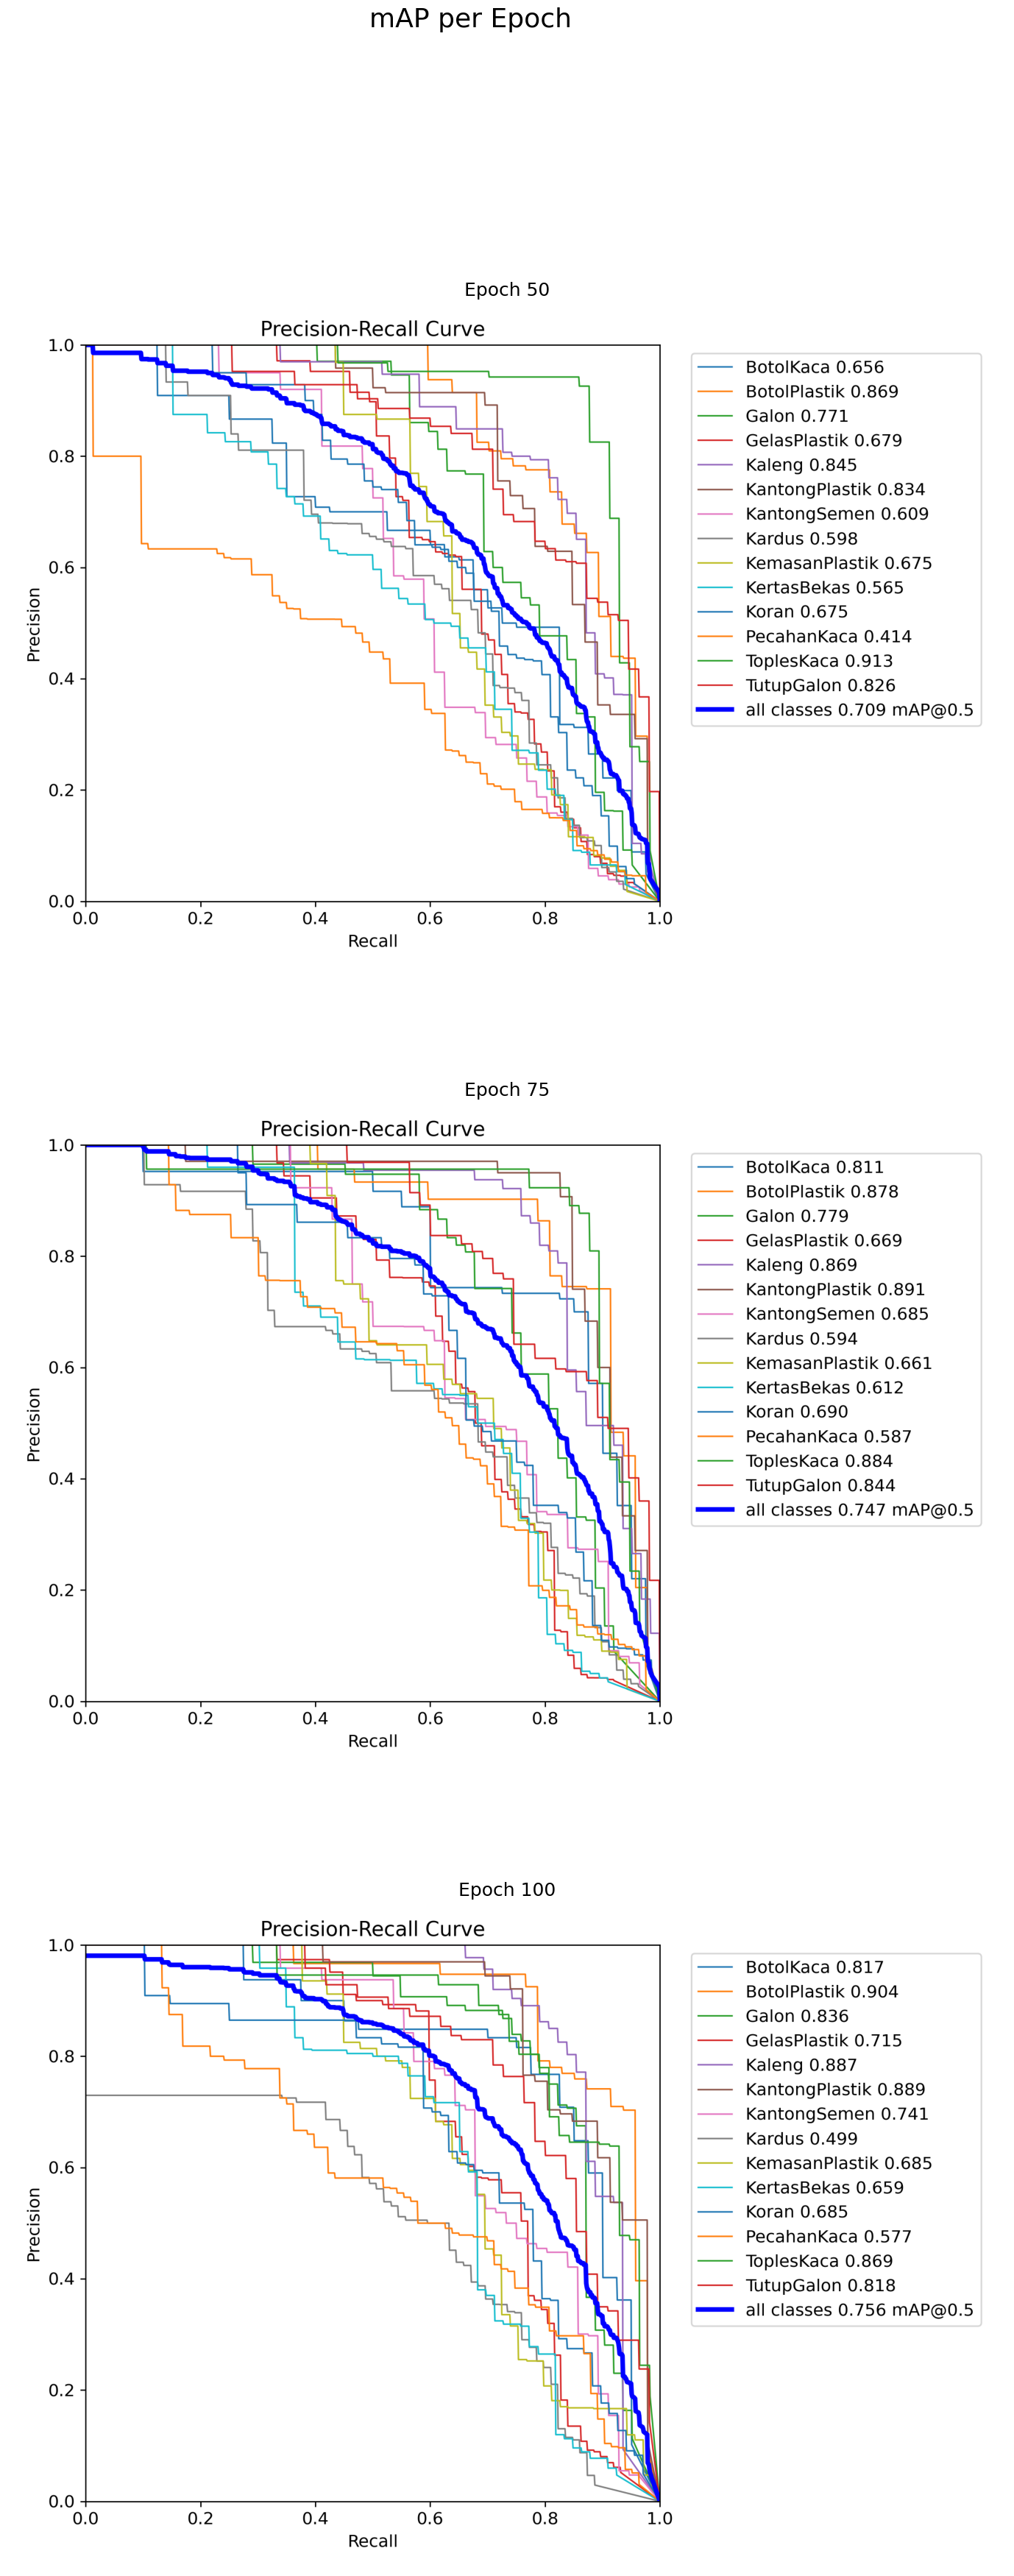

In [9]:
import cv2


image_paths = [
    "/notebooks/runs/detect/yolov8s_e50_lr0.01/PR_curve.png",
    "/notebooks/runs/detect/yolov8s_e75_lr0.01/PR_curve.png",
    "/notebooks/runs/detect/yolov8s_e100_lr0.01/PR_curve.png"
]

images = []
for path in image_paths:
    img = cv2.imread(path)
    if img is not None:
        images.append(img)
    else:
        print(f"Failed to load image at: {path}")
    
titles = ["Epoch 50", "Epoch 75", "Epoch 100"]
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(40,40)) 

for i, img in enumerate(images):
    if img is not None:
        rgb_image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axes[i].imshow(rgb_image)
        axes[i].axis('off')
        axes[i].set_title(titles[i], fontsize=18)
    else:
        axes[i].text(0.5, 0.5, 'Image not loaded', fontsize=18, ha='center')
        axes[i].axis('off')

plt.suptitle("mAP per Epoch", fontsize=26)
plt.show()

**EPOCH 50**
metrics/precision(B): 0.7114454981710879
metrics/recall(B): 0.635529880825082
metrics/mAP50(B): 0.7091065470804823
metrics/mAP50-95(B): 0.5960236257939584
fitness: 0.6073319179226109

**EPOCH 75**
metrics/precision(B): 0.7022723858308245
metrics/recall(B): 0.6908046243995309
metrics/mAP50(B): 0.7471534410614217
metrics/mAP50-95(B): 0.6368123974798225
fitness: 0.6478465018379824

**EPOCH 100**
metrics/precision(B): 0.7273333018285892
metrics/recall(B): 0.6918874537593281
metrics/mAP50(B): 0.7561402287922426
metrics/mAP50-95(B): 0.6511805226234924
fitness: 0.6616764932403674

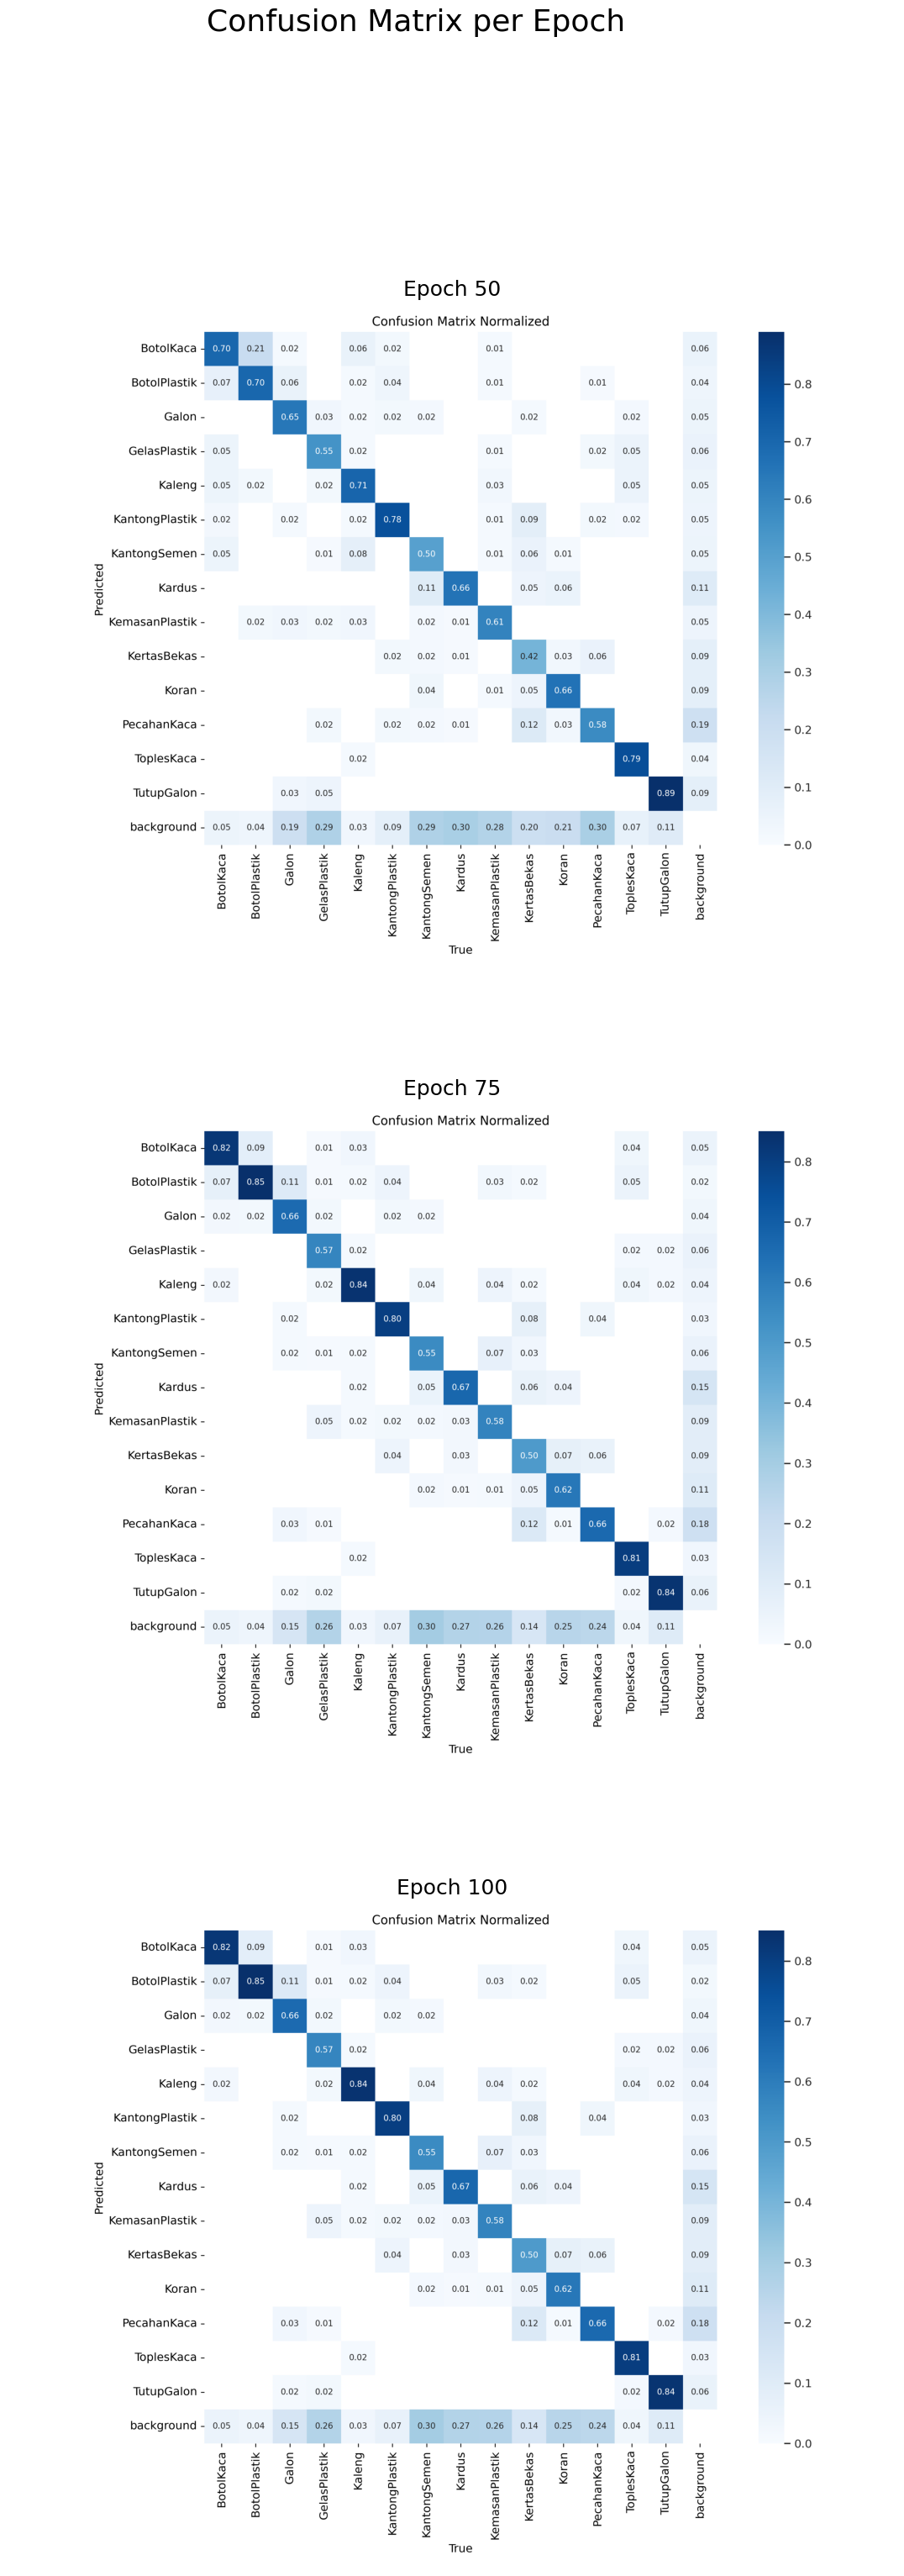

In [10]:
images = [cv2.imread(f) for f in [ "/notebooks/runs/detect/yolov8s_e50_lr0.01/confusion_matrix_normalized.png", 
                                   "/notebooks/runs/detect/yolov8s_e75_lr0.01/confusion_matrix_normalized.png", 
                                   "/notebooks/runs/detect/yolov8s_e75_lr0.01/confusion_matrix_normalized.png"]]

titles = ["Epoch 50", "Epoch 75", "Epoch 100"]

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(35, 35))

# Tampilkan setiap gambar pada axes yang sesuai
for i, img in enumerate(images):
    axes[i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axes[i].axis('off')
    axes[i].set_title(titles[i], fontsize=18)

# Tambahkan judul utama
plt.suptitle("Confusion Matrix per Epoch", fontsize=26)

plt.show()

# TEST MODEL 


0: 448x640 1 BotolKaca, 5 BotolPlastiks, 1 Galon, 5.6ms
Speed: 2.1ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 BotolPlastiks, 1 Galon, 4.9ms
Speed: 1.9ms preprocess, 4.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 3 BotolPlastiks, 1 Galon, 4.6ms
Speed: 1.9ms preprocess, 4.6ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


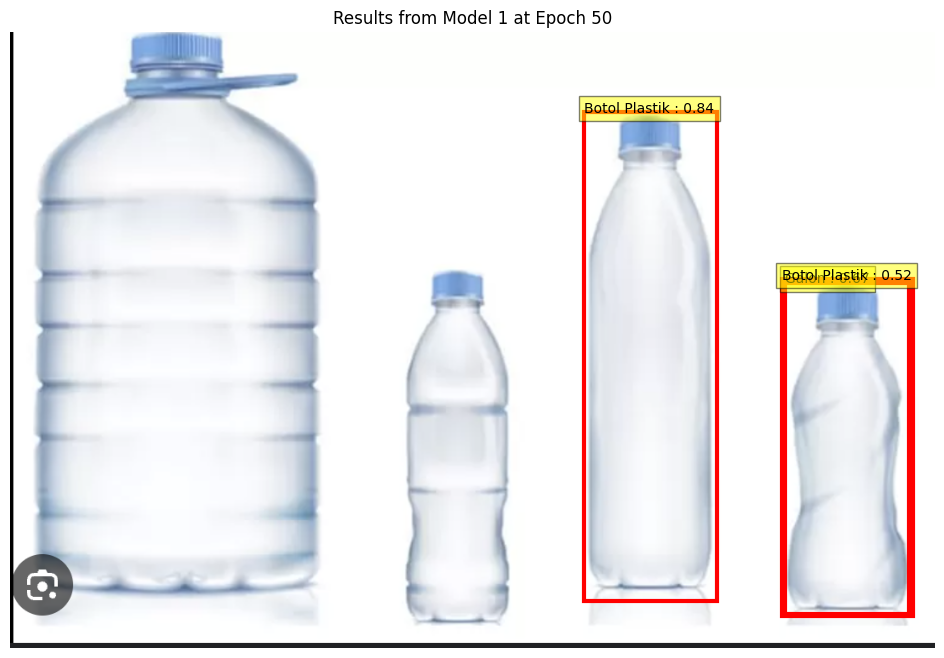

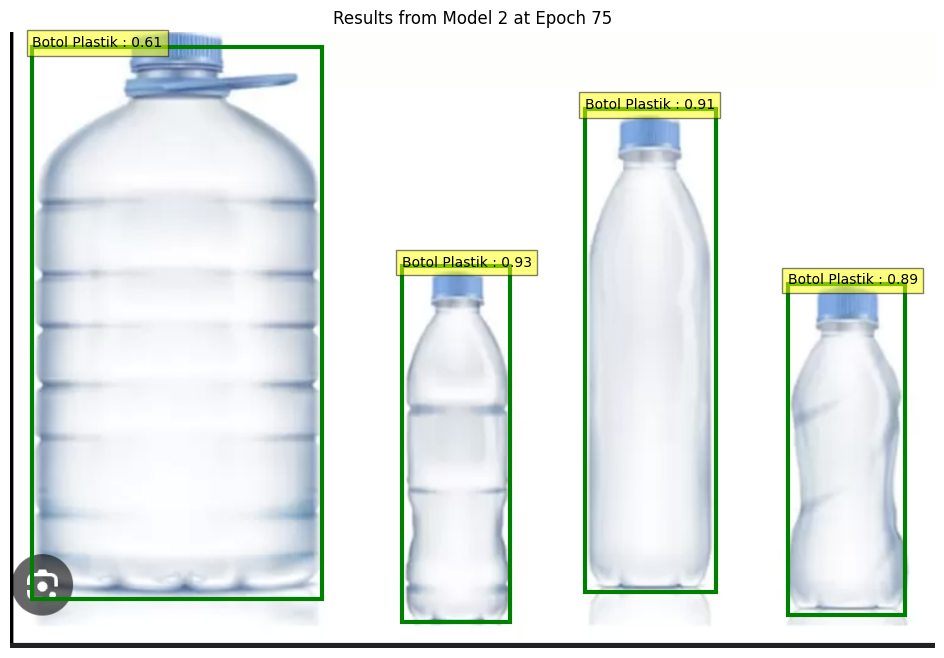

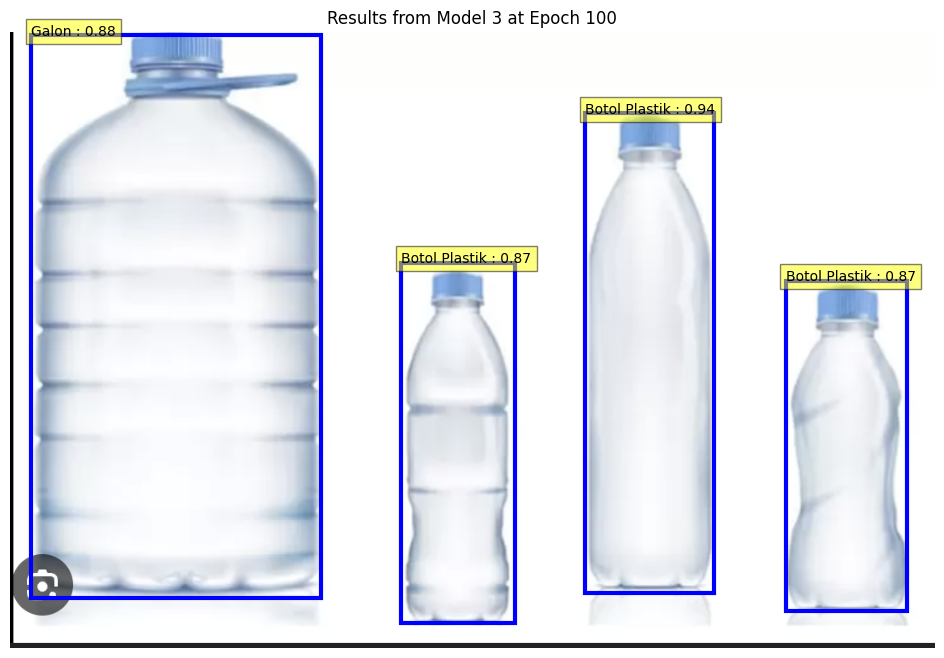

In [12]:

model1 = YOLO('/notebooks/runs/detect/yolov8s_e50_lr0.01/weights/best.pt')
model2 = YOLO('/notebooks/runs/detect/yolov8s_e75_lr0.01/weights/best.pt')
model3 = YOLO('/notebooks/runs/detect/yolov8s_e100_lr0.01/weights/best.pt')

# Define the class names (assuming all models were trained on the same classes)
class_names = [
    'Botol Kaca', 'Botol Plastik', 'Galon', 'Gelas Plastik', 'Kaleng',
    'Kantong Plastik', 'Kantong Semen', 'Kardus', 'Kemasan Plastik',
    'Kertas Bekas', 'Koran', 'Pecahan Kaca', 'Toples Kaca', 'Tutup Galon'
]

# Function to load an image
def load_image(image_path):
    img = Image.open(image_path).convert("RGB")
    return img

# Load your image
image_path = '/notebooks/botol dan galon.png'  # Update with the path to your image
original_image = load_image(image_path)

def plot_predictions(image, results, color, title):
    plt.figure(figsize=(12, 8))
    plt.imshow(image)
    ax = plt.gca()

    for result in results[0].boxes:
        x1, y1, x2, y2 = result.xyxy[0].cpu().numpy()
        score = result.conf[0].cpu().numpy()
        label = class_names[int(result.cls[0].cpu().numpy())]
        if score > 0.5:
            rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=3, edgecolor=color, facecolor='none')
            ax.add_patch(rect)
            plt.text(x1, y1, f'{label} : {score:.2f}', bbox=dict(facecolor='yellow', alpha=0.5))

    plt.axis('off')
    plt.title(title)
    plt.show()

# Perform detection with each model
results1 = model1(original_image)
results2 = model2(original_image)
results3 = model3(original_image)

plot_predictions(original_image, results1, 'r', "Results from Model 1 at Epoch 50")
plot_predictions(original_image, results2, 'g', "Results from Model 2 at Epoch 75")
plot_predictions(original_image, results3, 'b', "Results from Model 3 at Epoch 100")

# SAVE MODEL YOLOv8s

In [17]:
import os

# Define old and new paths
old_paths = [
    '/notebooks/runs/detect/yolov8s_e50_lr0.01/weights/best.pt',
    '/notebooks/runs/detect/yolov8s_e75_lr0.01/weights/best.pt',
    '/notebooks/runs/detect/yolov8s_e100_lr0.01/weights/best.pt'
]
new_directory = '/notebooks/models'
new_names = [
    'yolov8s_e50_0.01.pt',
    'yolov8s_e75_0.01.pt',
    'yolov8s_e100_0.01.pt'
]

# Create the new directory if it doesn't exist
os.makedirs(new_directory, exist_ok=True)

# Move and rename the models
for old_path, new_name in zip(old_paths, new_names):
    new_path = os.path.join(new_directory, new_name)
    os.rename(old_path, new_path)